# VQE

## Bibliografía

[PennyLane CodeMap: Introduction to Variational Quantum Algorithms (VQA)](https://pennylane.ai/codebook/variational-quantum-algorithms/parametrized-quantum-circuits): Puede venir bien por si hay algunas dudas de conceptos fundamentales

[PennyLane CodeMap: VQE](https://pennylane.ai/codebook/variational-quantum-algorithms/variational-quantum-eigensolver): Explicación Teórica + Ejercicios de Programación para practicar la implementación

[Ket-G: Hamiltoniano](https://www.youtube.com/watch?v=OXthrvvLhDw): Explicación teórica

[Ket-G: VQE](https://www.youtube.com/watch?v=dDVkAgU7hbo): Explicación Teórica

[Ket-G: Programando el algoritmo VQE](https://www.youtube.com/watch?v=jFTKKJ1sIaE): Implementación del algoritmo VQE

In [1]:
# INDICAR SI ESTAMOS EN COLAB O NO (JUPYTER POR EJEMPLO)
colab = False
if colab:
    !pip install pennylane

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

EL **Variational Quantum Eigensolver (VQE)** es el algoritmo de tipo variacional más sencillo, el cual está diseñado (entre muchas otras cosas) para resolver problemas de tipo *QUBO* (Quadratic Unconstrained Binary Optimization), es decir, problemas de *combinatoria binaria* en los que la función objetivo es de esta forma:

$$
min f(x) = x^T Ax + bx
$$

donde $x = (x_1,...,x_n)$, con $x_i \in \{0,1\}$, $A$ es una matriz tal que el elemento $a_{ij}$ multiplica al producto $x_ix_j$ y $b$ es un vector tal que el elemento $b_i$ multiplica a $x_i$. Además, este tipo de problemas en un principio *no admite restricciones*, pero se puede probar a introducir las restricciones en la función objetivo en forma de *penalizaciones*, aunque el rendimiento no será tan alto.

Además, entra en la familia de algoritmos **híbridos** (propio de la familia de algoritmos *Variational Quantum Algorithms (VQA)*, debido a la combinación de un *circuito cuántico* junto con un algoritmo de *optimización clásica* para hallar los mejores valores de los parámetros del circuito.

## 1. Idea del algoritmo

El objetivo de este algoritmo es encontrar el **valor propio más pequeño de un observable**. Este observable se suele denominar como **Hamiltoniano**, el cual representa la *energía de un sistema*. ¡Entonces lo que estamos buscando es el **estado de mínima energía** de un sistema!



Sabemos que, aunque sea más o menos laborioso, todo circuito cuántico se puede expresar como una matriz de tamaño $2^n \times 2^n$, siendo $n$ el número de cúbits. Imaginemos que tenemos esta matriz, que es nuestro **Hamiltoniano**:

$$
\begin{pmatrix} f(0) & 0 & \dots & 0 \\ 0 & f(1) & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & f(2^n-1)  \end{pmatrix}
$$

tal que $0$ es $0..0$ en binario, $1$ es $0...01$, ..., y $2^n-1$ es $1...1$. Uno de esos valores $f(i)$ es el de mínima energía; el que estamos buscando.

Este algoritmo sigue el **principio variacional**: vamos a crear un **circuito inicial**, independiente de nuestro Hamiltoniano y que pueda crear cualquier estado; además, vamos a hacer que este circuito dependa de unos **parámetros**. Generaremos un estado cuántico $|\psi \rangle$, sobre el cual mediremos el valor esperado del Hamiltoniano $\langle \psi |H|\psi \rangle$.  

Y nos podemos preguntar, una vez tenemos esa matriz, ¿cómo consigo ese $f(x)$ que es la respuesta a mi problema de optimización? De la siguiente forma: si quiero el primer valor de la diagonal, $f(0)$, me basta con hacer:

$$
\langle 0| \begin{pmatrix} f(0) & 0 & \dots & 0 \\ 0 & f(1) & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & f(2^n-1)  \end{pmatrix} | 0 \rangle = \begin{pmatrix} 1 & 0 & ... & 0 \end{pmatrix} \begin{pmatrix} f(0) & 0 & \dots & 0 \\ 0 & f(1) & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & f(2^n-1)  \end{pmatrix} \begin{pmatrix} 1 \\ 0 \\ \vdots \\ 0 \end{pmatrix} = f(0)
$$

Es decir, para conseguir $f(i)$, me basta con hacer
$$
\langle i|\begin{pmatrix} f(0) & 0 & \dots & 0 \\ 0 & f(1) & \dots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \dots & f(2^n-1)  \end{pmatrix} |i\rangle
$$
siendo $|i\rangle$ el vector con todo ceros salvo un $1$ en la posición $i-1$. El objetivo del algoritmo es que el **circuito inicial cree el estado** $|i\rangle$ **para obtener** $f(i)$, el estado de mínima energía. El circuito inicial que debemos construir dado nuestro Hamiltoniano, recibe el nombre de **ansatz**.

**¿Y cómo sabemos cuál es ese ansatz?** Para eso están esos **parámetros** de los cuales depende. Los distintos valores esperados del circuito harán que los parámetros **vayan variando en cada iteración**, con la esperanza de ir hallando **menores y menores energías** del sistema hasta hallar el estado de mínima energía, en donde nuestro circuito generará $|i\rangle$.

¿Y cómo es el **circuito de nuestro Hamiltoniano**? Partimos de nuestro conjunto de variables binarias $x_i \in \{0, 1\}$. Para trabajar con problemas QUBO, lo tenemos que convertir a un modelo **Ising**, en donde trabajamos con variables $z_i \in  \{-1, 1\}$. Hacemos esto porque se trasladan directamente a nuestro circuito a **operadores de Pauli** $Z$. Para ello, podemos hacer el cambio $x_i = \frac{1-z_i}{2}$, porque si $x_i = 0 → z_i = 1$, y si $x_i = 1 → z_i = -1$.

Vamos a ver qué significa tener una función dependiente de $z_i$ y su circuito asociado. Si por ejemplo tenermos la función $f(z_0,z_1) = 2z_0-z_0z_1$, el primer término se traduce a un subcircuito en el que el cable asociado al cúbit $0$ tiene una puerta $Z$ (y el cúbit $1$ la puerta Identidad o directamente nada), mientras que el segundo término se traduce a un subcircuito con una puerta $Z$ tanto para el primer como para el segundo cúbit. Los coeficientes $2$ y $-1$ multiplican a las matrices asociadas a dichos subcircuitos.

Y te puedes preguntar, **¿y por qué no podemos implementar un solo circuito para construir el Hamiltoniano?** Porque necesitamos que las **matrices sean unitarias**. Por eso hemos dividido nuestro Hamiltoniano en suma de matrices que sí que sabemos que son unitarias (y de hecho, se calcula el valor esperado del Hamiltoniano en cada subcircuito y luego se suman los resultados).

## PROBLEMA KET-G

Vamos a ver cómo se implementaría este algoritmo en dos problemas.

El primer problema consiste en minimizar la función $f(x_0,x_1,x_2) = 2x_0-4x_0x_1+3x_1x_2$, donde $x_i \in \{0,1\}$. Su mínimo es cuando $x_0 = 1, x_1 = 1, x_2 = 0$, con $f(1,1,0) = -3$.

El primer paso es hacer el **cambio de variable** $x_i = \frac{1-z_i}{2}$ para obtener así nuestro **Hamiltoniano**:

$$
f(Z_0, Z_1, Z_2) = 2 \frac{1-Z_0}{2} -4 \frac{1-Z_0}{2} \frac{1-Z_1}{2} + 3 \frac{1-Z_1}{2} \frac{1-Z_2}{2} = \dots = \frac{3}{4} + \frac{Z_1}{4}-\frac{3Z_2}{4} -Z_0Z_1+\frac{3Z_1Z_2}{4}
$$

Dos apuntes: los términos constantes ($\frac{3}{4}$ en este ejemplo) se pueden omitir (de hecho, es extremandamente recomendable) porque lo único que hacen es añadir energía al sistema en todos los casos (lo cual no ayuda a encontrar la solución óptima y consume recursos computacionales). Y si nuestro problema fuese a **maximizar**, tendríamos que **invertir el signo** de todos los términos.

La matriz asociada a nuestro Hamiltoniano es:

$$
\begin{pmatrix} f(z_0=0,z_1=0,z_2=0) & 0 & ... & 0 \\ 0 & f(z_0=0,z_1=0,z_2=1) & ... & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & ... & f(z_0=1,z_1=1,z_2=1) \end{pmatrix}
$$

Una forma frecuente de programar el Hamiltoniano es con dos listas, una de coeficientes y otra de observables, donde el primer elemento de ambas corresponde al primer término del Hamiltoniano, e ídem con el resto.

In [2]:
# Dispositivo
n_wires = 3
dev = qml.device("default.qubit", wires=n_wires)

# Hamiltoniano (f(x0,x1,x2) = 2x0 - 4x0x1 + 3x1x2)
coeffs = [-0.75, 0.25, -1.0, 0.75]
obs = [
    qml.PauliZ(2),
    qml.PauliZ(1),
    qml.PauliZ(0) @ qml.PauliZ(1),
    qml.PauliZ(1) @ qml.PauliZ(2)
]
H = qml.Hamiltonian(coeffs, obs)

Ahora vamos a definir el  **ansatz**, el cual queremos que nos ayude a encontrar el estado de mínima energía. Para alcanzar todos los posibles estados, definimos una serie de puertas rotatorias en el eje $Y$ y $X$, y relacionamos los cubits entre sí con puertas $CNOT$.

Luego, definimos la función que representa el **circuito total**; es decir, el circuito inicial y la medida del valor esperado en función a nuestro Hamiltoniano.

In [4]:
def ansatz(params):
    for i in range(n_wires):
        qml.RY(params[i], wires=i)
    for i in range(n_wires - 1):
        qml.CNOT(wires=[i, i+1])
    for i in range(n_wires):
        qml.RX(params[n_wires+i], wires=i)

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.expval(H)

Ahora, aunque pueda parecer un poco redundante, para mejorar la claridad de la programación, creamos una función de coste que llama al circuito, la cual se pasa al optimizador que definimos después (se podrían haber usado otros optimizadores, como el Adam).

Step 0 - Cost: 0.4984
Step 10 - Cost: -0.4900
Step 20 - Cost: -0.7520
Step 30 - Cost: -0.8105
Step 40 - Cost: -0.9021
Step 50 - Cost: -1.2166
Step 60 - Cost: -2.1106
Step 70 - Cost: -2.6583
Step 80 - Cost: -2.7390
Step 90 - Cost: -2.7487
Step 100 - Cost: -2.7498
Step 110 - Cost: -2.7500
Step 120 - Cost: -2.7500
Step 130 - Cost: -2.7500
Step 140 - Cost: -2.7500

Final cost: -2.749999994687863
Optimal parameters: [3.14159347e+00 6.28318531e+00 3.14159266e+00 6.28308224e+00
 1.24589274e-09 1.20587144e-07]


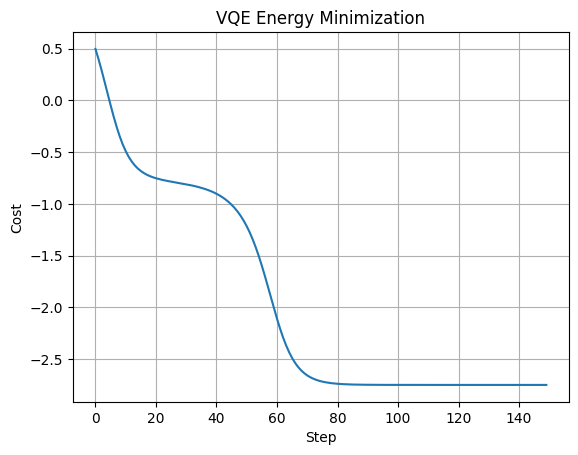

In [6]:
# Función de costo
def cost(params):
    return circuit(params)

# Inicialización aleatoria
np.random.seed(42)
params = np.random.uniform(0, 2*np.pi, size=(2*n_wires,))

# Optimizador
stepsize = 0.1
opt = qml.GradientDescentOptimizer(stepsize = stepsize)
steps = 150
costs = []

for i in range(steps):
    params = opt.step(cost, params)
    c = cost(params)
    costs.append(c)
    if i % 10 == 0:
        print(f"Step {i} - Cost: {c:.4f}")

# Mostrar resultado
print("\nFinal cost:", cost(params))
print("Optimal parameters:", params)

# Visualización
plt.plot(costs)
plt.xlabel("Step")
plt.ylabel("Cost")
plt.title("VQE Energy Minimization")
plt.grid(True)
plt.show()

Un consejo: este algoritmo convergerá probabilísticamente al óptimo si el paso es suficientemente pequeño y el número de iteraciones suficientemente grande. A mayor dimensionalidad del problema, deberás establecer un paso más pequeño y más iteraciones. Para asegurar llegar al óptimo, intenta en primer lugar establecer dos valores de paso e iteraciones que te permitan llegar con seguridad al óptimo (aunque en la gráfica de coste veas después que con un menor número de iteraciones habrías llegado también al menor coste), y luego ve reduciendo el número de iteraciones y/o aumenta el paso. También puede ocurrir que si el paso es demasiado pequeño, se atasque en óptimos locales de los cuales no pueda salir...

De hecho, en este problema, con esta configuración, con 100 iteraciones habrían bastado, pero así nos cercioramos de que estamos en el óptimo.

Si la gráfica parece ruido y el coste no tiene una tendencia general a disminuir, el paso es muy grande, y si el coste baja pero no ha terminado de bajar al terminar el algoritmo, aumenta el número de iteraciones.

Una vez llegados a este punto, ¡ya tendremos los parámetros optimizados! Vamos a ejecutar una última vez este circuito pero devolviendo las probabilidades de los diferentes estados para luego ordenarlos según su probabilidad de observación.


Top bitstrings (most probable):
(1, 1, 0): 1.0000
(0, 1, 0): 0.0000
(0, 0, 1): 0.0000
(1, 1, 1): 0.0000
(1, 0, 0): 0.0000
(1, 0, 1): 0.0000
(0, 1, 1): 0.0000
(0, 0, 0): 0.0000


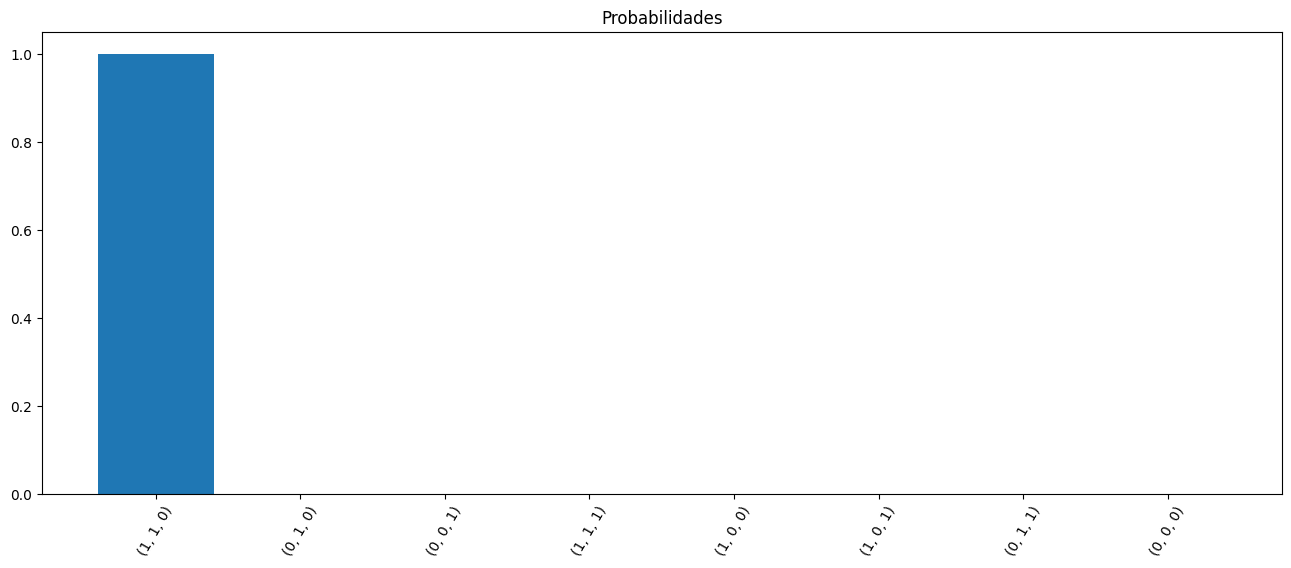

In [7]:
@qml.qnode(dev)
def probability_circuit(params):
    ansatz(params)
    return qml.probs(wires=range(n_wires))

probs = probability_circuit(params)
bitstrings = list(product([0, 1], repeat=n_wires))

formato = '0'+str(n_wires)+'b'
for i, p in enumerate(probs):
    bitstring = format(i, formato)  # convierte 0-2^n-1 a '0...0' - '1...1'

sorted_results = sorted(zip(probs, bitstrings), reverse=True)

print("\nTop bitstrings (most probable):")
for prob, bits in sorted_results[:10]:
    print(f"{bits}: {prob:.4f}")

grupos = [sorted_results[i][0] for i in range(len(sorted_results))]
probs = [''.join(str(sorted_results[i][1])) for i in range(len(sorted_results))]

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(probs, grupos)
ax.tick_params(axis='x', labelrotation=60)
ax.set_title('Probabilidades')
plt.show()

Se ve que el único estado que se observará es $x_0 = 1, x_1 = 1, x_2 = 0$, ¡que de hecho es nuestro óptimo! ¡Se ve cómo llegar al mínimo coste hace que sólo se observe el estado óptimo!

## Reparto de Números

Vamos ahora con otro problema que es sencillo de entender pero más complicado de solucionar al menos a mano (de hecho, es un problema NP, es decir, no resoluble en tiempo polinomial).

Imagina que tienes una serie de objetos $L$ con valores $v_1,...,v_k, v_i \in \mathbb{R}^+$. Tu objetivo es distribuir los objetos en dos subconjuntos de forma que estén lo más equilibrados posibles (según sus valores).

Con pocos objetos este problema es trivial, pero a medida que ponemos más y más objetos, ¡este problema se vuelve muy complicado de solucionar! Vamos a ver cómo solucinarlo de forma cuántica.

Hay que definir la función a optimizar y el correspondiente Hamiltoniano. Podemos escribir la siguiente función:

$$
min \bigg( \sum_{i=1}^k s_iv_i \bigg)^2 = min \sum_{i=1}^k s_i^2 v_i^2 + 2 \sum_{j, \ i<j} s_is_jv_iv_j
$$

donde $s_i=1$ si el objeto $i$ va al subconjunto $L_1$ y $s_i=-1$ si va al subconjunto $L_2$. De hecho, podemos resumir esto último a

$$
min \sum_{j, \ i<j} s_is_jv_iv_j
$$

porque la puerta de Pauli $Z$ al cuadrado es la identidad (la debemos obviar) y el $2$ que multiplica al otro sumatorio es irrelevante.

¿Y cómo sabemos que esta fórmula nos sirve para nuestro propósito? Desarrollando el término a la izquierda de la igualdad:

$$
min \bigg( \sum_{i=1}^k s_iv_i \bigg)^2 = min \bigg( \sum_{i \in L_1}^k v_i - \sum_{i \in L_2}^k v_i \bigg)^2
$$

Esto será mínimo cuánto más iguales sean los grupos. Además, tenemos una ventaja respecto a la codificación del anterior problema; como hemos definido nuestras variables $s_i \in \{-1,1\}$, ¡no hace falta hacer ninguna transformación! Es como si $s_i = z_i$ del anterior problema (se traducen directamente a puertas de Pauli $Z$).

A la hora de programar el Hamiltoniano, aquí estamos obligados a no considerar el primer sumatorio $\sum_{i=1}^k s_i^2 v_i^2$ porque da error a la hora de intentar optimizar los parámetros del ansatz.

El resto del código es prácticamente igual (ajustar algunos valores como `n_wires`, `stepsize`, `steps`, definir la lista de valores...)

Step 0 - Cost: 746.1808
Step 10 - Cost: 648.0118
Step 20 - Cost: 548.4573
Step 30 - Cost: 447.4585
Step 40 - Cost: 345.0259
Step 50 - Cost: 241.2397
Step 60 - Cost: 136.2332
Step 70 - Cost: 30.1755
Step 80 - Cost: -76.7425
Step 90 - Cost: -184.3177
Step 100 - Cost: -292.3418
Step 110 - Cost: -400.6055
Step 120 - Cost: -508.9026
Step 130 - Cost: -617.0316
Step 140 - Cost: -724.7986
Step 150 - Cost: -832.0183
Step 160 - Cost: -938.5151
Step 170 - Cost: -1044.1246
Step 180 - Cost: -1148.6938
Step 190 - Cost: -1252.0823
Step 200 - Cost: -1354.1624
Step 210 - Cost: -1454.8198
Step 220 - Cost: -1553.9544
Step 230 - Cost: -1651.4802
Step 240 - Cost: -1747.3265
Step 250 - Cost: -1841.4373
Step 260 - Cost: -1933.7709
Step 270 - Cost: -2024.2977
Step 280 - Cost: -2112.9970
Step 290 - Cost: -2199.8518
Step 300 - Cost: -2284.8455
Step 310 - Cost: -2367.9599
Step 320 - Cost: -2449.1761
Step 330 - Cost: -2528.4771
Step 340 - Cost: -2605.8501
Step 350 - Cost: -2681.2888
Step 360 - Cost: -2754.7948
St

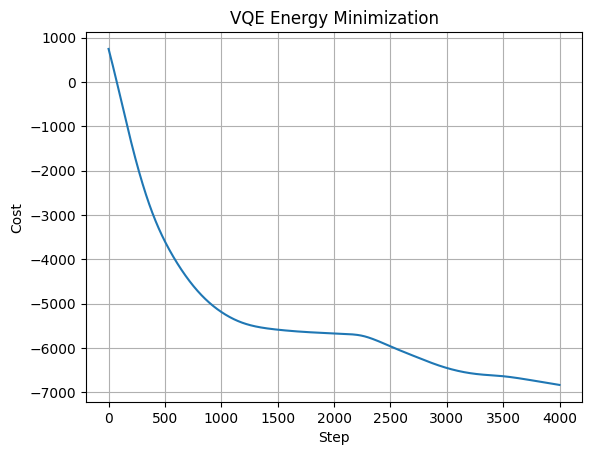


Top bitstrings (agrupando por complemento):
[('00000001', tensor(0.44439946, requires_grad=True)), ('00001001', tensor(0.26708938, requires_grad=True)), ('00010001', tensor(0.14898501, requires_grad=True)), ('00011001', tensor(0.06763494, requires_grad=True)), ('00001110', tensor(0.02638041, requires_grad=True)), ('00010110', tensor(0.0217961, requires_grad=True)), ('00000110', tensor(0.0149288, requires_grad=True)), ('01000001', tensor(0.00380141, requires_grad=True)), ('01001001', tensor(0.00228469, requires_grad=True)), ('01010001', tensor(0.00127442, requires_grad=True)), ('01011001', tensor(0.00057855, requires_grad=True)), ('00011110', tensor(0.00030442, requires_grad=True)), ('01001110', tensor(0.00022566, requires_grad=True)), ('01010110', tensor(0.00018644, requires_grad=True)), ('01000110', tensor(0.0001277, requires_grad=True)), ('01011110', tensor(2.60401453e-06, requires_grad=True)), ('00000011', tensor(5.0496597e-10, requires_grad=True)), ('00000000', tensor(3.89569318e-

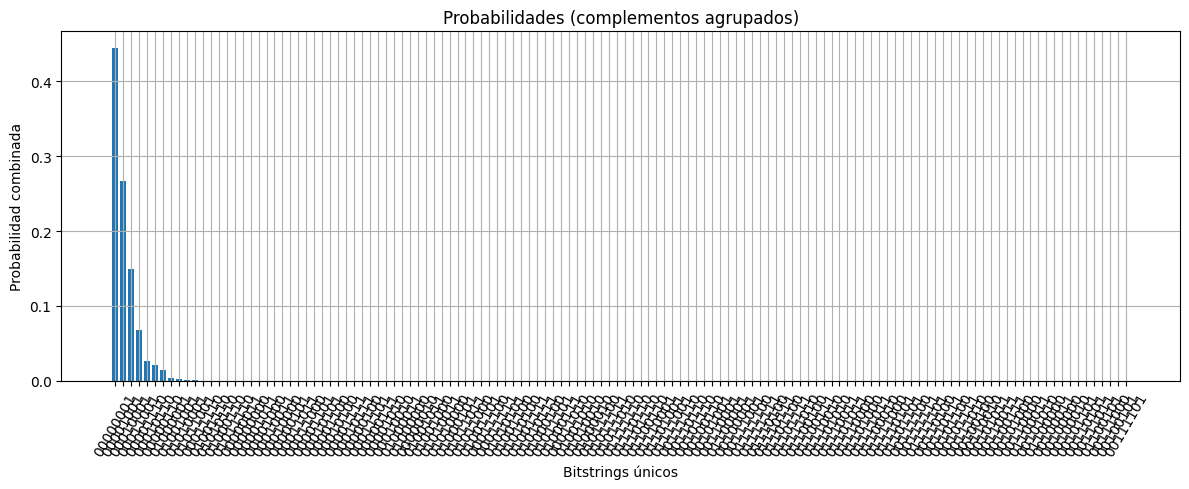

In [ ]:
# Dispositivo
numbers = [1,3,4,7,13,25,51,103]
# numbers = [1,3,4,7,13]
n_wires = len(numbers)
dev = qml.device("default.qubit", wires=n_wires)

def cost_hamiltonian():
    coeffs = []
    obs = []
    for i in range(n_wires):
        for j in range(n_wires):
            if i<j:
                coeff = numbers[i] * numbers[j]
                op = qml.PauliZ(i) @ qml.PauliZ(j)
                coeffs.append(coeff)
                obs.append(op)
    return qml.Hamiltonian(coeffs, obs)

H = cost_hamiltonian()

# Ansatz de prueba
def ansatz(params):
    for i in range(n_wires):
        qml.RY(params[i], wires=i)
    for i in range(n_wires - 1):
        qml.CNOT(wires=[i, i+1])
    for i in range(n_wires):
        qml.RX(params[n_wires+i], wires=i)

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.expval(H)

# Función de costo
def cost(params):
    return circuit(params)

# Inicialización aleatoria
np.random.seed(42)
params = np.random.uniform(0, 2*np.pi, size=(2*n_wires,))

# Optimizador
stepsize = 0.001 # 0.01 para 5, 0.005 para 6/7, 0.001 para 8
opt = qml.optimize.AdamOptimizer(stepsize)
steps = 4000 # 600 para 5, 1000 para 6/7, 4000 para 8

costs = []

for i in range(steps):
    params = opt.step(cost, params)
    c = cost(params)
    costs.append(c)
    if i % 100 == 0:
        print(f"Step {i} - Cost: {c:.4f}")

# Mostrar resultado
print("\nFinal cost:", cost(params))
print("Optimal parameters:", params)

# Visualización
plt.plot(costs)
plt.xlabel("Step")
plt.ylabel("Cost")
plt.title("VQE Energy Minimization")
plt.grid(True)
plt.show()

@qml.qnode(dev)
def probability_circuit(params):
    ansatz(params)
    return qml.probs(wires=range(n_wires))

# Guardamos las probabilidades originales y bitstrings
raw_probs = probability_circuit(params)
bitstrings = list(product([0, 1], repeat=n_wires))

# Agrupamos por complemento
grouped_probs = defaultdict(float)
seen = set()

for i, bits in enumerate(bitstrings):
    prob = raw_probs[i]
    bstr = ''.join(map(str, bits))
    comp = ''.join('1' if b == '0' else '0' for b in bstr)

    key = min(bstr, comp)
    grouped_probs[key] += prob
    seen.add(key)

# Mostrar resultados agrupados
print("\nTop bitstrings (agrupando por complemento):")
top_grouped = sorted(grouped_probs.items(), key=lambda x: x[1], reverse=True)
print(top_grouped)
for bstr, prob in top_grouped:
    print(f"{bstr}: {prob:.4f}")

def print_partition(bitstring, numbers):
    group_0 = [num for bit, num in zip(bitstring, numbers) if bit == 0]
    group_1 = [num for bit, num in zip(bitstring, numbers) if bit == 1]
    sum_0 = sum(group_0)
    sum_1 = sum(group_1)
    print(f"Group 0: {group_0}  (sum = {sum_0})")
    print(f"Group 1: {group_1}  (sum = {sum_1})")
    print(f"Difference: {abs(sum_0 - sum_1)}\n")
print("\nBest partition (from most probable bitstring):")
bitstring_str = top_grouped[0][0]  # bitstring como string, e.g. '010'
bitstring_list = [int(b) for b in bitstring_str]  # convertimos a [0,1,0]
print_partition(bitstring_list, numbers)

# Graficar
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar([k for k, _ in top_grouped[:20]], [v for _, v in top_grouped[:20]])
ax.set_title("Probabilidades (complementos agrupados)")
ax.set_xlabel("Bitstrings únicos")
ax.set_ylabel("Probabilidad combinada")
plt.xticks(rotation=60)
plt.grid(True)
plt.tight_layout()
plt.show()

Vemos que (para el caso de 8 objetos), podríamos haber dejado más iteraciones para que una de las dos soluciones óptimas tuviesen una mayor probabilidad de ser observado, pero por recursos computacionales hemos decicido dejarlo así.

## PROBLEMA DE LA MOCHILA con slack variables (no funciona del todo bien) 

Step 0 - Cost: 100.2279
Step 10 - Cost: 61.1328
Step 20 - Cost: 30.5115
Step 30 - Cost: 6.3733
Step 40 - Cost: -13.5420
Step 50 - Cost: -30.8758
Step 60 - Cost: -45.7252
Step 70 - Cost: -57.3927
Step 80 - Cost: -65.9261
Step 90 - Cost: -72.2596
Step 100 - Cost: -77.4246
Step 110 - Cost: -82.1684
Step 120 - Cost: -86.7954
Step 130 - Cost: -91.2724
Step 140 - Cost: -95.4125
Step 150 - Cost: -99.0273
Step 160 - Cost: -102.0575
Step 170 - Cost: -104.5931
Step 180 - Cost: -106.8054
Step 190 - Cost: -108.8739
Step 200 - Cost: -110.9133
Step 210 - Cost: -112.9015
Step 220 - Cost: -114.7173
Step 230 - Cost: -116.2828
Step 240 - Cost: -117.5470
Step 250 - Cost: -118.4736
Step 260 - Cost: -119.1076
Step 270 - Cost: -119.5148
Step 280 - Cost: -119.7627
Step 290 - Cost: -119.9065
Step 300 - Cost: -119.9866
Step 310 - Cost: -120.0296
Step 320 - Cost: -120.0522
Step 330 - Cost: -120.0639
Step 340 - Cost: -120.0704
Step 350 - Cost: -120.0745
Step 360 - Cost: -120.0777
Step 370 - Cost: -120.0808
Step 

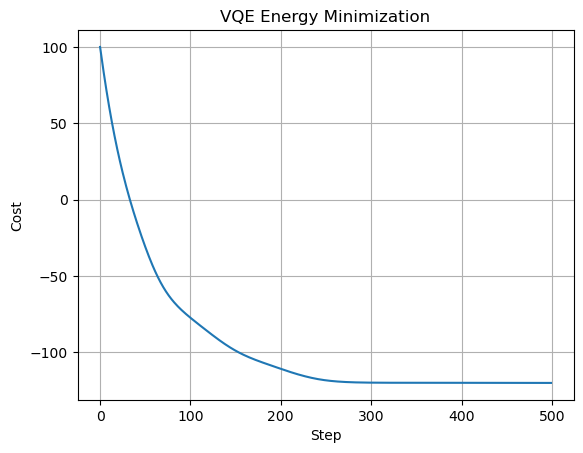

In [3]:
# Parámetros del problema
v = np.array([1, 2, 3])          # valores de los ítems (n = 3)
w = np.array([3, 4, 2])          # pesos de los ítems (n = 3)
n = len(w)
W = 7                           # capacidad máxima
k = int(np.log2(W)) + 1          # número de bits para slack variable
P = 10                            # penalización

n_wires = n + k
dev = qml.device("default.qubit", wires=n_wires)

# Cálculo de la constante C
C = 0.5 * np.sum(w) + 0.5 * np.sum([2**j for j in range(k)]) - W
def cost_hamiltonian():

    # Inicializamos listas de coeficientes y operadores
    coeffs = []
    ops = []

    # Valores introducidos en la mochila
    for i in range(n):
        coeffs.append(-0.5*v[i])
        ops.append(qml.PauliZ(i))

    # Penalizaciones
    # Términos lineales en Z_i (items)
    for i in range(n):
        coeffs.append(-P * C * w[i])
        ops.append(qml.PauliZ(i))

    # Términos lineales en Z_{n+j} (slack variables)
    for j in range(k):
        coeffs.append(-P * C * 2**(j))
        ops.append(qml.PauliZ(n + j))

    # Términos cuadráticos Z_i Z_k (items)
    for i in range(n):
        for k_ in range(i+1, n):
            coeffs.append(0.5 * P * w[i] * w[k_])
            ops.append(qml.PauliZ(i) @ qml.PauliZ(k_))

    # Términos cuadráticos Z_{n+j} Z_{n+l} (slack variables)
    for j in range(k):
        for l in range(j+1, k):
            coeffs.append(0.5 * P * 2**(j) * 2**(l))
            ops.append(qml.PauliZ(n + j) @ qml.PauliZ(n + l))

    # Términos mixtos Z_i Z_{n+j}
    for i in range(n):
        for j in range(k):
            coeffs.append(0.5 * P * w[i] * 2**(j))
            ops.append(qml.PauliZ(i) @ qml.PauliZ(n + j))

    # Construcción del Hamiltoniano
    return qml.Hamiltonian(coeffs, ops)

H = cost_hamiltonian()

# Ansatz de prueba
def ansatz(params):
    for i in range(n_wires):
        qml.RY(params[i], wires=i)
    for i in range(n_wires - 1):
        qml.CNOT(wires=[i, i+1])
    for i in range(n_wires):
        qml.RX(params[n_wires+i], wires=i)

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.expval(H)

# Función de costo
def cost(params):
    return circuit(params)

# Inicialización aleatoria
np.random.seed(42)
params = np.random.uniform(0, 2*np.pi, size=(2*n_wires,))

# Optimizador
stepsize = 0.01 # 0.01 para 5, 0.005 para 6/7, 0.001 para 8
opt = qml.optimize.AdamOptimizer(stepsize)
steps = 500 # 600 para 5, 1000 para 6/7, 4000 para 8

costs = []

for i in range(steps):
    params = opt.step(cost, params)
    c = cost(params)
    costs.append(c)
    if i % 10 == 0:
        print(f"Step {i} - Cost: {c:.4f}")

# Mostrar resultado
print("\nFinal cost:", cost(params))
print("Optimal parameters:", params)

# Visualización
plt.plot(costs)
plt.xlabel("Step")
plt.ylabel("Cost")
plt.title("VQE Energy Minimization")
plt.grid(True)
plt.show()


Top bitstrings (most probable):
(1, 0, 0, 1, 0, 1): 0.2205
(1, 0, 1, 0, 1, 0): 0.2172
(0, 1, 1, 0, 1, 0): 0.2084
(0, 1, 0, 1, 0, 1): 0.2060
(1, 0, 0, 0, 0, 1): 0.0376
(1, 0, 1, 1, 1, 0): 0.0371
(0, 1, 1, 1, 1, 0): 0.0356
(0, 1, 0, 0, 0, 1): 0.0351
(0, 0, 0, 1, 0, 1): 0.0013
(0, 0, 1, 0, 1, 0): 0.0007


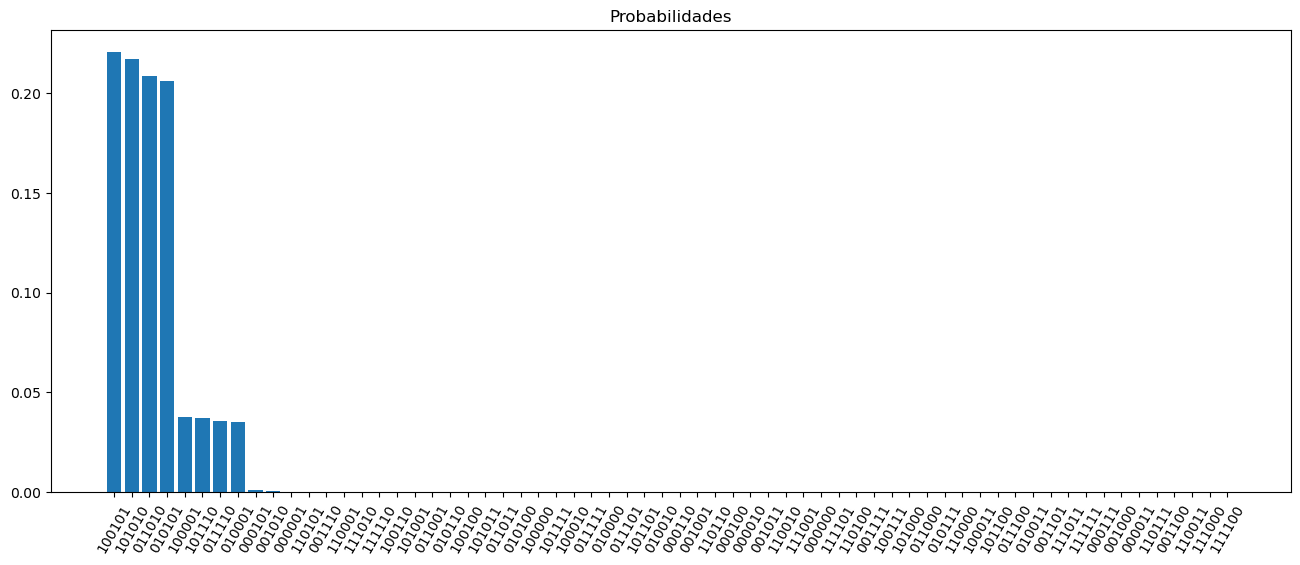

In [4]:
@qml.qnode(dev)
def probability_circuit(params):
    ansatz(params)
    return qml.probs(wires=range(n_wires))

# Probabilidades
probs_values = probability_circuit(params)
bitstrings = list(product([0, 1], repeat=n_wires))

sorted_results = sorted(zip(probs_values, bitstrings), key=lambda x: x[0], reverse=True)

print("\nTop bitstrings (most probable):")
for prob, bits in sorted_results[:10]:
    print(f"{bits}: {prob:.4f}")

# Preparar datos para el gráfico
probabilities = [x[0] for x in sorted_results]
bitstrings_str = [''.join(map(str, x[1])) for x in sorted_results]

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(bitstrings_str, probabilities)
ax.tick_params(axis='x', rotation=60)
ax.set_title('Probabilidades')
plt.show()